# Experiment : Frozen Noise Classification

In this experiment, the simulator will be used to classify two random frozen noise patterns

### Imports

In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

from typing import Optional, Tuple, Any

# Utils
import numpy as np
from tqdm import tqdm

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential


from rockpool.devices.dynapse import (
    DynapSim,
    mapper,
    parameter_clustering,
    autoencoder_quantization,
    config_from_specification,
    find_dynapse_boards,
    DynapseSamna,
)

from rockpool.nn.modules.module import ModuleBase

# - Plotting and config
import matplotlib.pyplot as plt

# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12


# Step 1 : Input 

In [2]:
def poisson_spike_train(
    n_channels: int,
    duration: float,
    rate: float,
    dt: float,
    batch_size: int = 1,
    seed: Optional[int] = None,
) -> np.ndarray:
    """
    random_spike_train generates a Poisson frozen random spike train

    :param n_channels: number of channels
    :type n_channels: float
    :param duration: simulation duration in seconds
    :type duration: float
    :param rate: expected mean spiking rate in Hertz(1/s)
    :type rate: float
    :param dt: time step length
    :type dt: float, optional
    :param batch_size: number of batches in data, defaults to 1
    :type batch_size: int, optional
    :param seed: the random number seed
    :type seed: int, optional
    :raises ValueError: no spike generated due to low firing rate or very short simulation time
    :return: randomly generated discrete spike train
    :rtype: np.ndarray
    """
    np.random.seed(seed)
    steps = int(np.round(duration / dt))
    raster = np.random.poisson(rate * dt, (batch_size, steps, n_channels))

    # Check if raster has at least one spike
    if not any(raster.flatten()):
        raise ValueError(
            "No spike generated at all due to low firing rate or short simulation time duration!"
        )

    spike_tensor = np.array(raster, dtype=float)
    return spike_tensor
    
class FrozenNoise:
    def __init__(
        self,
        n_samples: int,
        n_channels: int = 60,
        duration: float = 500e-3,
        dt: float = 1e-3,
        rate: float = 50,
        seed: Optional[float] = 2022,
    ):
        self.n_in = n_channels
        self.n_out = n_samples
        self.input_raster=poisson_spike_train(n_channels, duration, rate, dt, batch_size=n_samples, seed=seed)
        self.targets = np.expand_dims(np.identity(n_samples, dtype=float), 1)

    def __getitem__(self, index) -> Tuple[np.ndarray, int]:
        return self.input_raster[index], self.targets[index]

    def __len__(self) -> int:
        return self.n_out


In [3]:
dataset = FrozenNoise(2)
dataset2 = FrozenNoise(10, seed=2023)

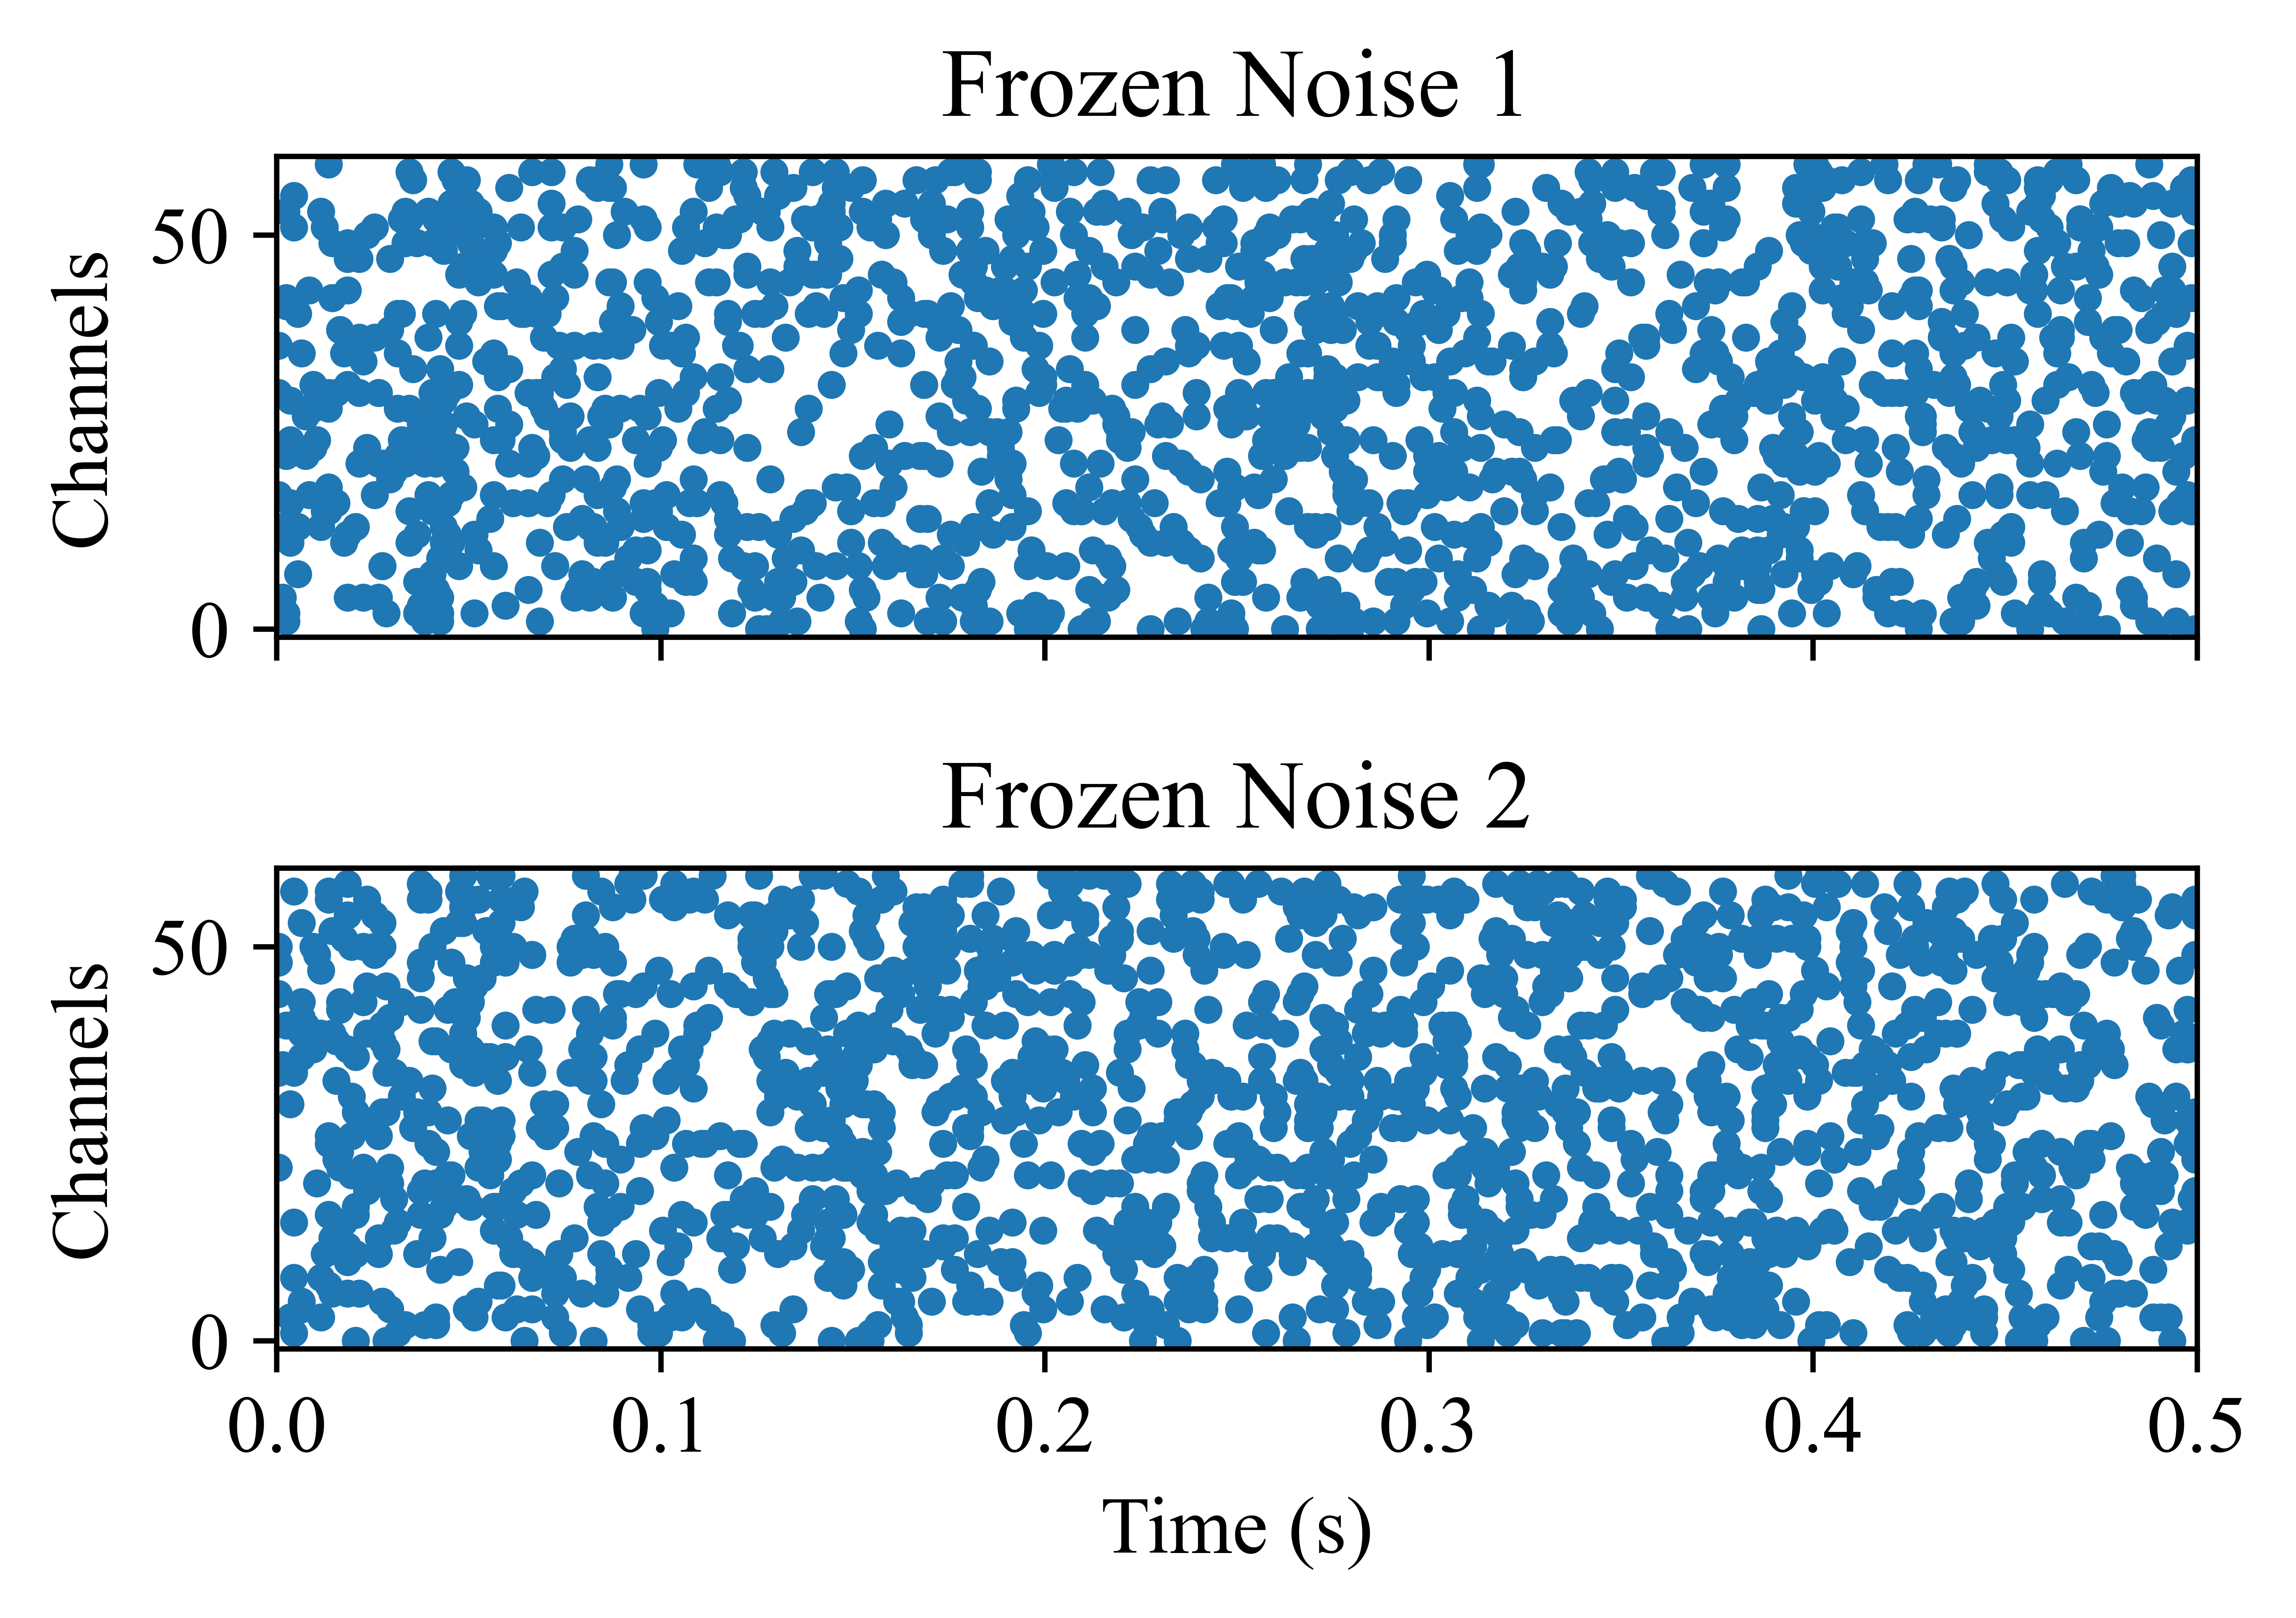

In [4]:
plt.rcParams["figure.figsize"] = [4.9, 3.5]

def plot_input(dataset : Any):
    fig, axes = plt.subplots(len(dataset),1,sharex=True)
    
    for i, ax in enumerate(axes):
        plt.sca(ax)
        noise = TSEvent.from_raster(dataset[i][0], dt=1e-3, name=f"Frozen Noise {i+1}")
        noise.plot(s=10)
        plt.xlabel("")

    plt.xlabel("Time (s)")
    plt.tight_layout()

plot_input(dataset)
# plt.savefig("noise_patterns_2.png", transparent="True", bbox_inches="tight")


## Step 2 : Network Configuration

Using the simulation configuration object, create a dynapse simulator

In [5]:
# --- Input Layer --- #
linear_in = LinearJax(
    shape=(dataset.n_in, dataset.n_out),
    has_bias=False,
)
linear_in


LinearJax  with shape (60, 2)

In [6]:
# --- DynapSim Layer --- #
Nrec = dataset.n_out
dynapsim = DynapSim((Nrec, Nrec), Iscale=1e-7, has_rec=True, w_rec=np.random.rand(Nrec,Nrec))
dynapsim

DynapSim  with shape (2, 2)

In [7]:
model = Sequential(linear_in, dynapsim)
model

JaxSequential  with shape (60, 2) {
    LinearJax '0_LinearJax' with shape (60, 2)
    DynapSim '1_DynapSim' with shape (2, 2)
}

Output 1 = [[116. 108.]]
Output 2 = [[114. 116.]]


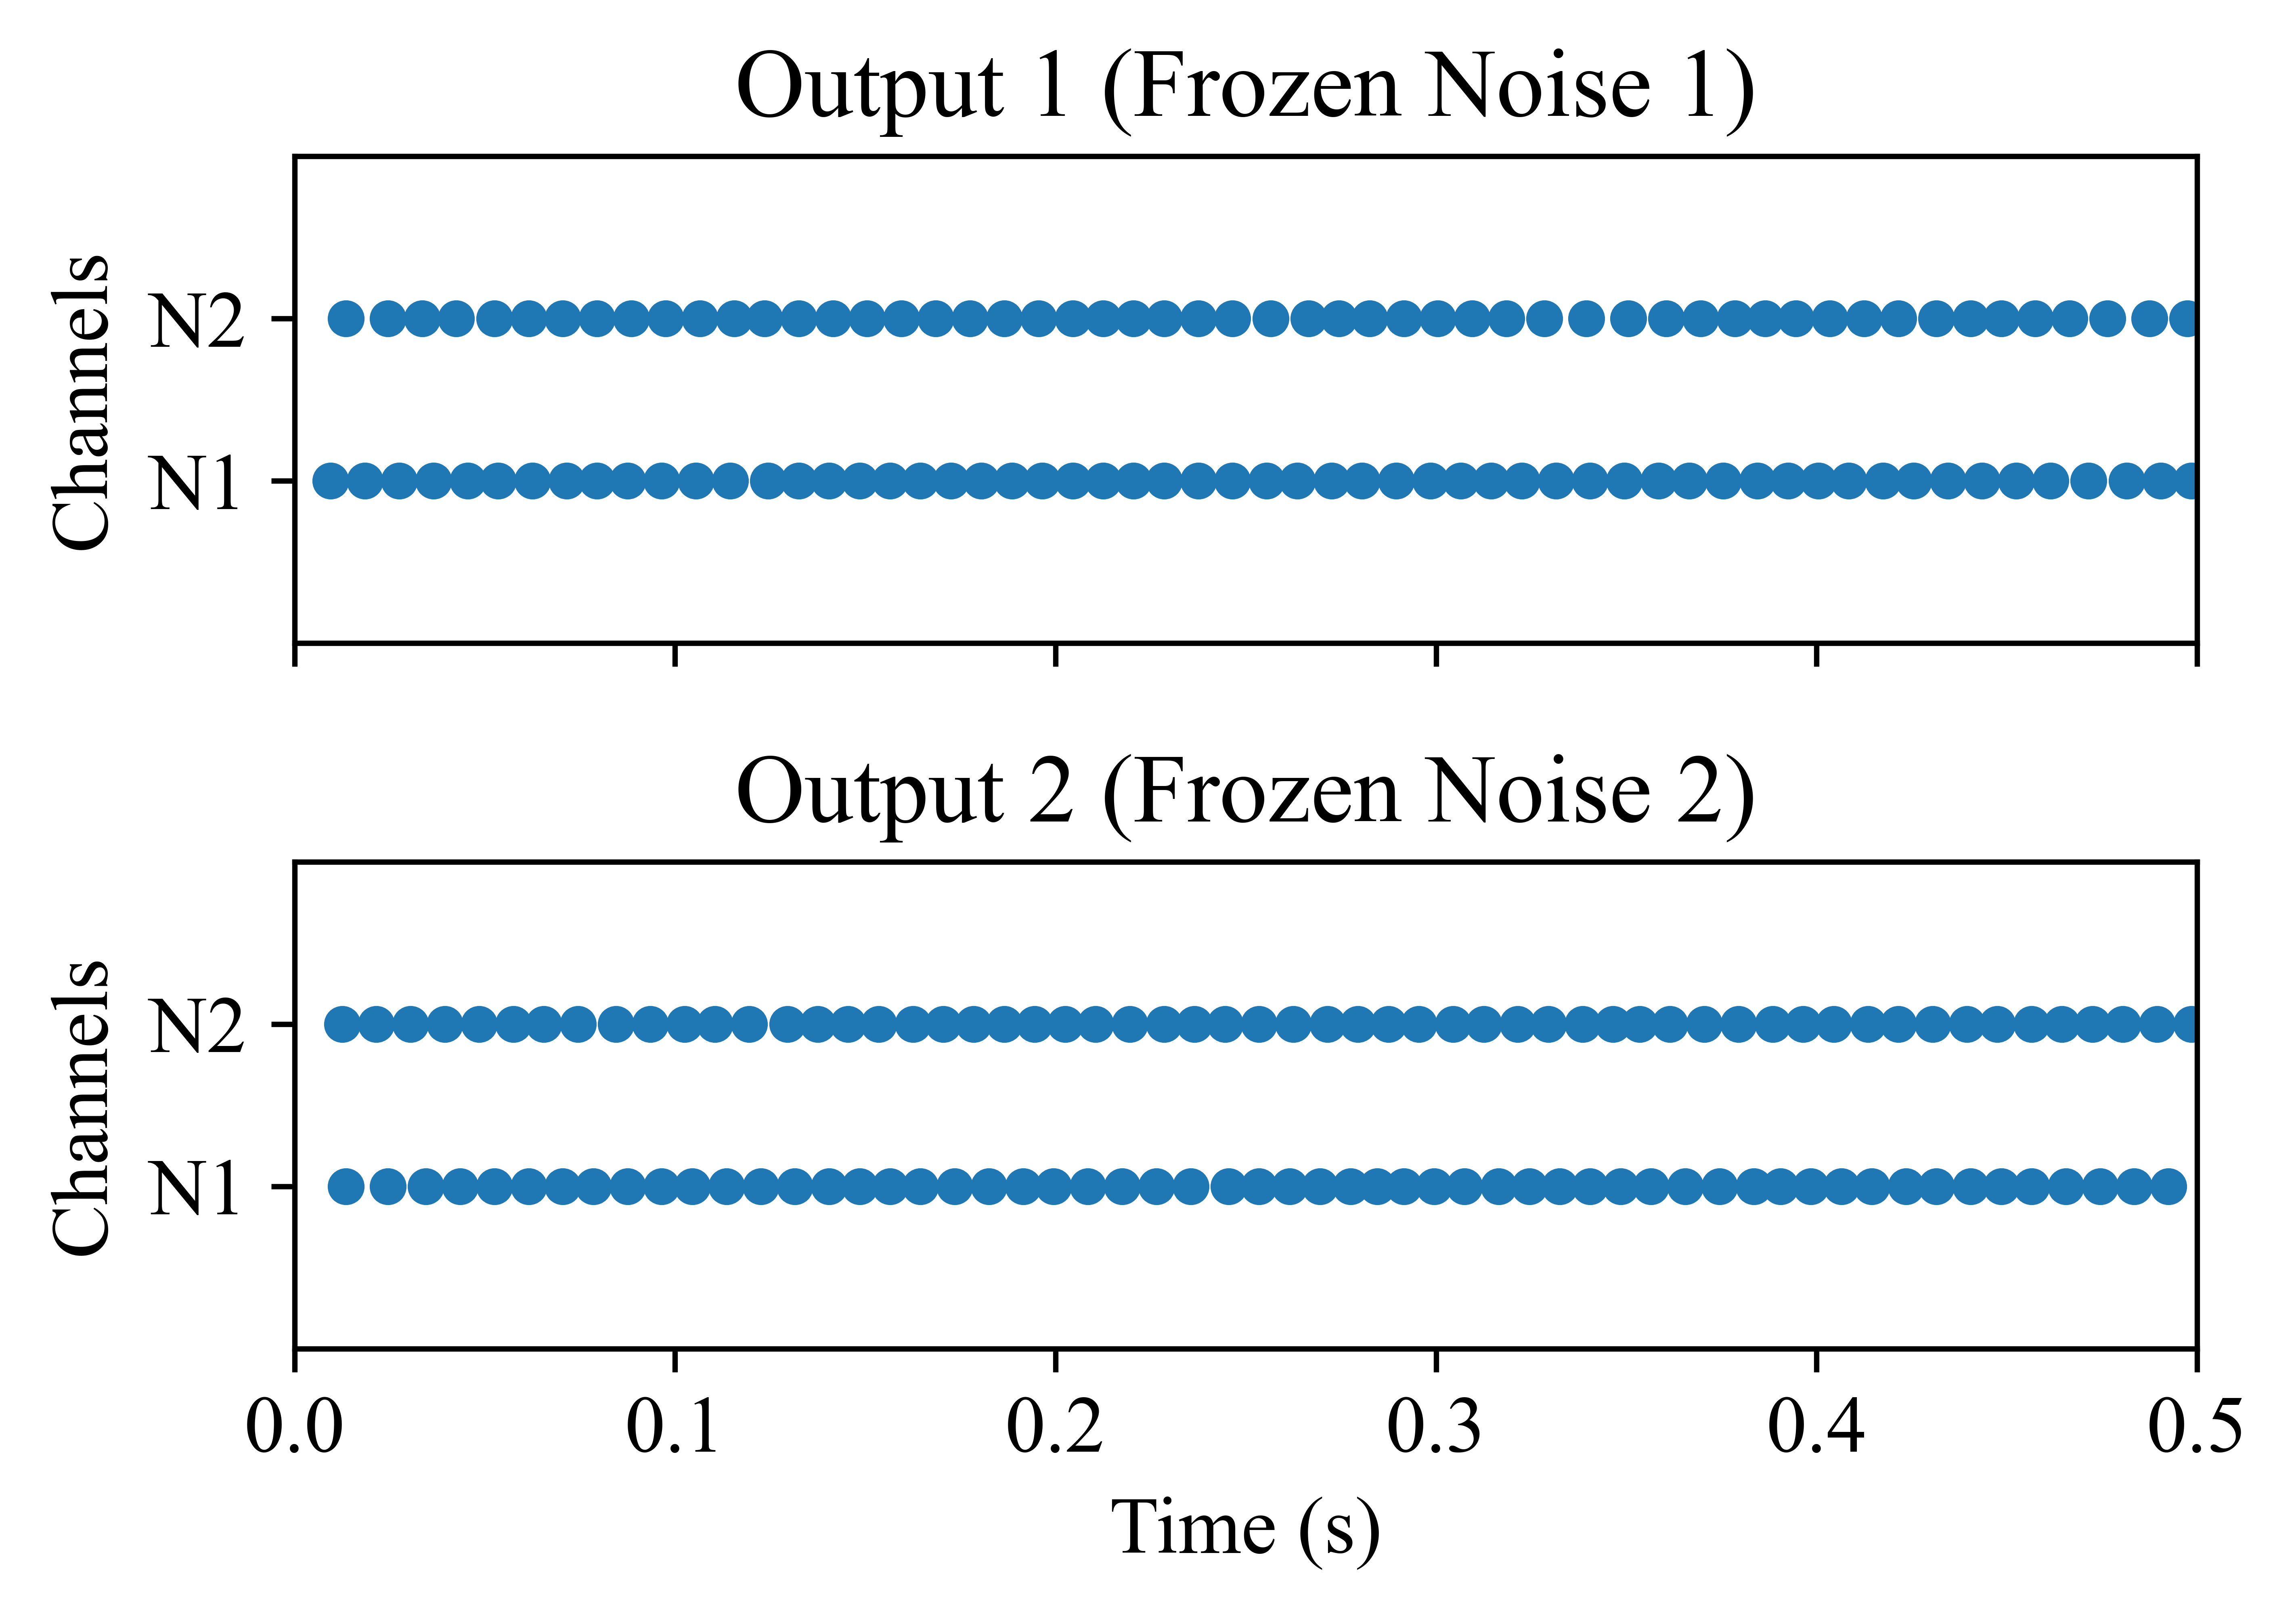

In [8]:
def plot_output(model: ModuleBase, dataset : Any):
    fig, axes = plt.subplots(len(dataset),1,sharex=True)
    rec = []
    for i, ax in enumerate(axes):
        plt.sca(ax)
        inp, target = dataset[i]
        model.reset_state()
        out, _, rec_i = model(inp)
        output = TSEvent.from_raster(out[0], dt=1e-3, name=f"Output {i+1} (Frozen Noise {i+1})")
        output.plot(s=20)
        plt.yticks([0,1], ["N1", "N2"])
        rec.append(rec_i)
        plt.xlabel("")
        print(f"Output {i+1} = {np.sum(out,axis=1)*2}")

    plt.xlabel("Time (s)")
    plt.tight_layout()
    return rec

rec = plot_output(model, dataset)

# plt.savefig("fn_output_2.png", transparent="True", bbox_inches="tight")

In [9]:
# def plot_mem(rec_list):
#     fig, axes = plt.subplots(len(rec_list),1,sharex=True)
#     for i,(ax,rec) in enumerate(zip(axes,rec_list)):
#         plt.sca(ax)
#         plt.title(f"Response {i+1}")
#         Figure.plot_Ix(rec["1_DynapSim"]["vmem"][0], ax=ax)
#         handles, _ = ax.get_legend_handles_labels()
#         ax.legend(handles, ["$V_{mem_{1}}$", "$V_{mem_{2}}$"], bbox_to_anchor=(1, 1.04))
#         plt.xlabel("")
#         plt.ylabel("Voltage (V)")
#         plt.tight_layout()
        

#     plt.xlabel("Time (s)")

# plot_mem(rec)
# plt.savefig("fn_response.png", transparent="True", bbox_inches="tight")

## Step 3 : Optimization

In [10]:
# - Jax imports
import jax
from jax.experimental.optimizers import adam
from rockpool.training import jax_loss as jl
from itertools import count

# - Initialise optimiser
learning_rate = 1e-3
bounds_penalty = 1e3

In [11]:
init_fun, update_fun, get_params = adam(learning_rate)
opt_state = init_fun(model.parameters())
update_fun = jax.jit(update_fun)

# - Loss function
@jax.jit
@jax.value_and_grad
def loss_vgf(params, net, input, target):
    net = net.set_attributes(params)
    net = net.reset_state()
    output, _, _ = net(input)
    return jl.mse(output, target)

In [12]:
batch_input, batch_target  = dataset[:,:,:]

In [13]:
loss_t = []

In [14]:
# # - Configure learning
# num_epochs = int(1.2e6)

# # - Training loop
# t = tqdm(range(num_epochs), desc='Training', unit='Epoch', total=num_epochs)
    
# for epoch in t:
#     # - Get parameters
#     opt_parameters = get_params(opt_state)

#     # - Compute loss and gradient
#     l, g = loss_vgf(opt_parameters, model, batch_input, batch_target)
#     loss_t.append(l.item())
#     t.set_postfix({'loss': l.item()}, refresh = False)

#     # - Update optimiser
#     opt_state = update_fun(epoch, g, opt_state)

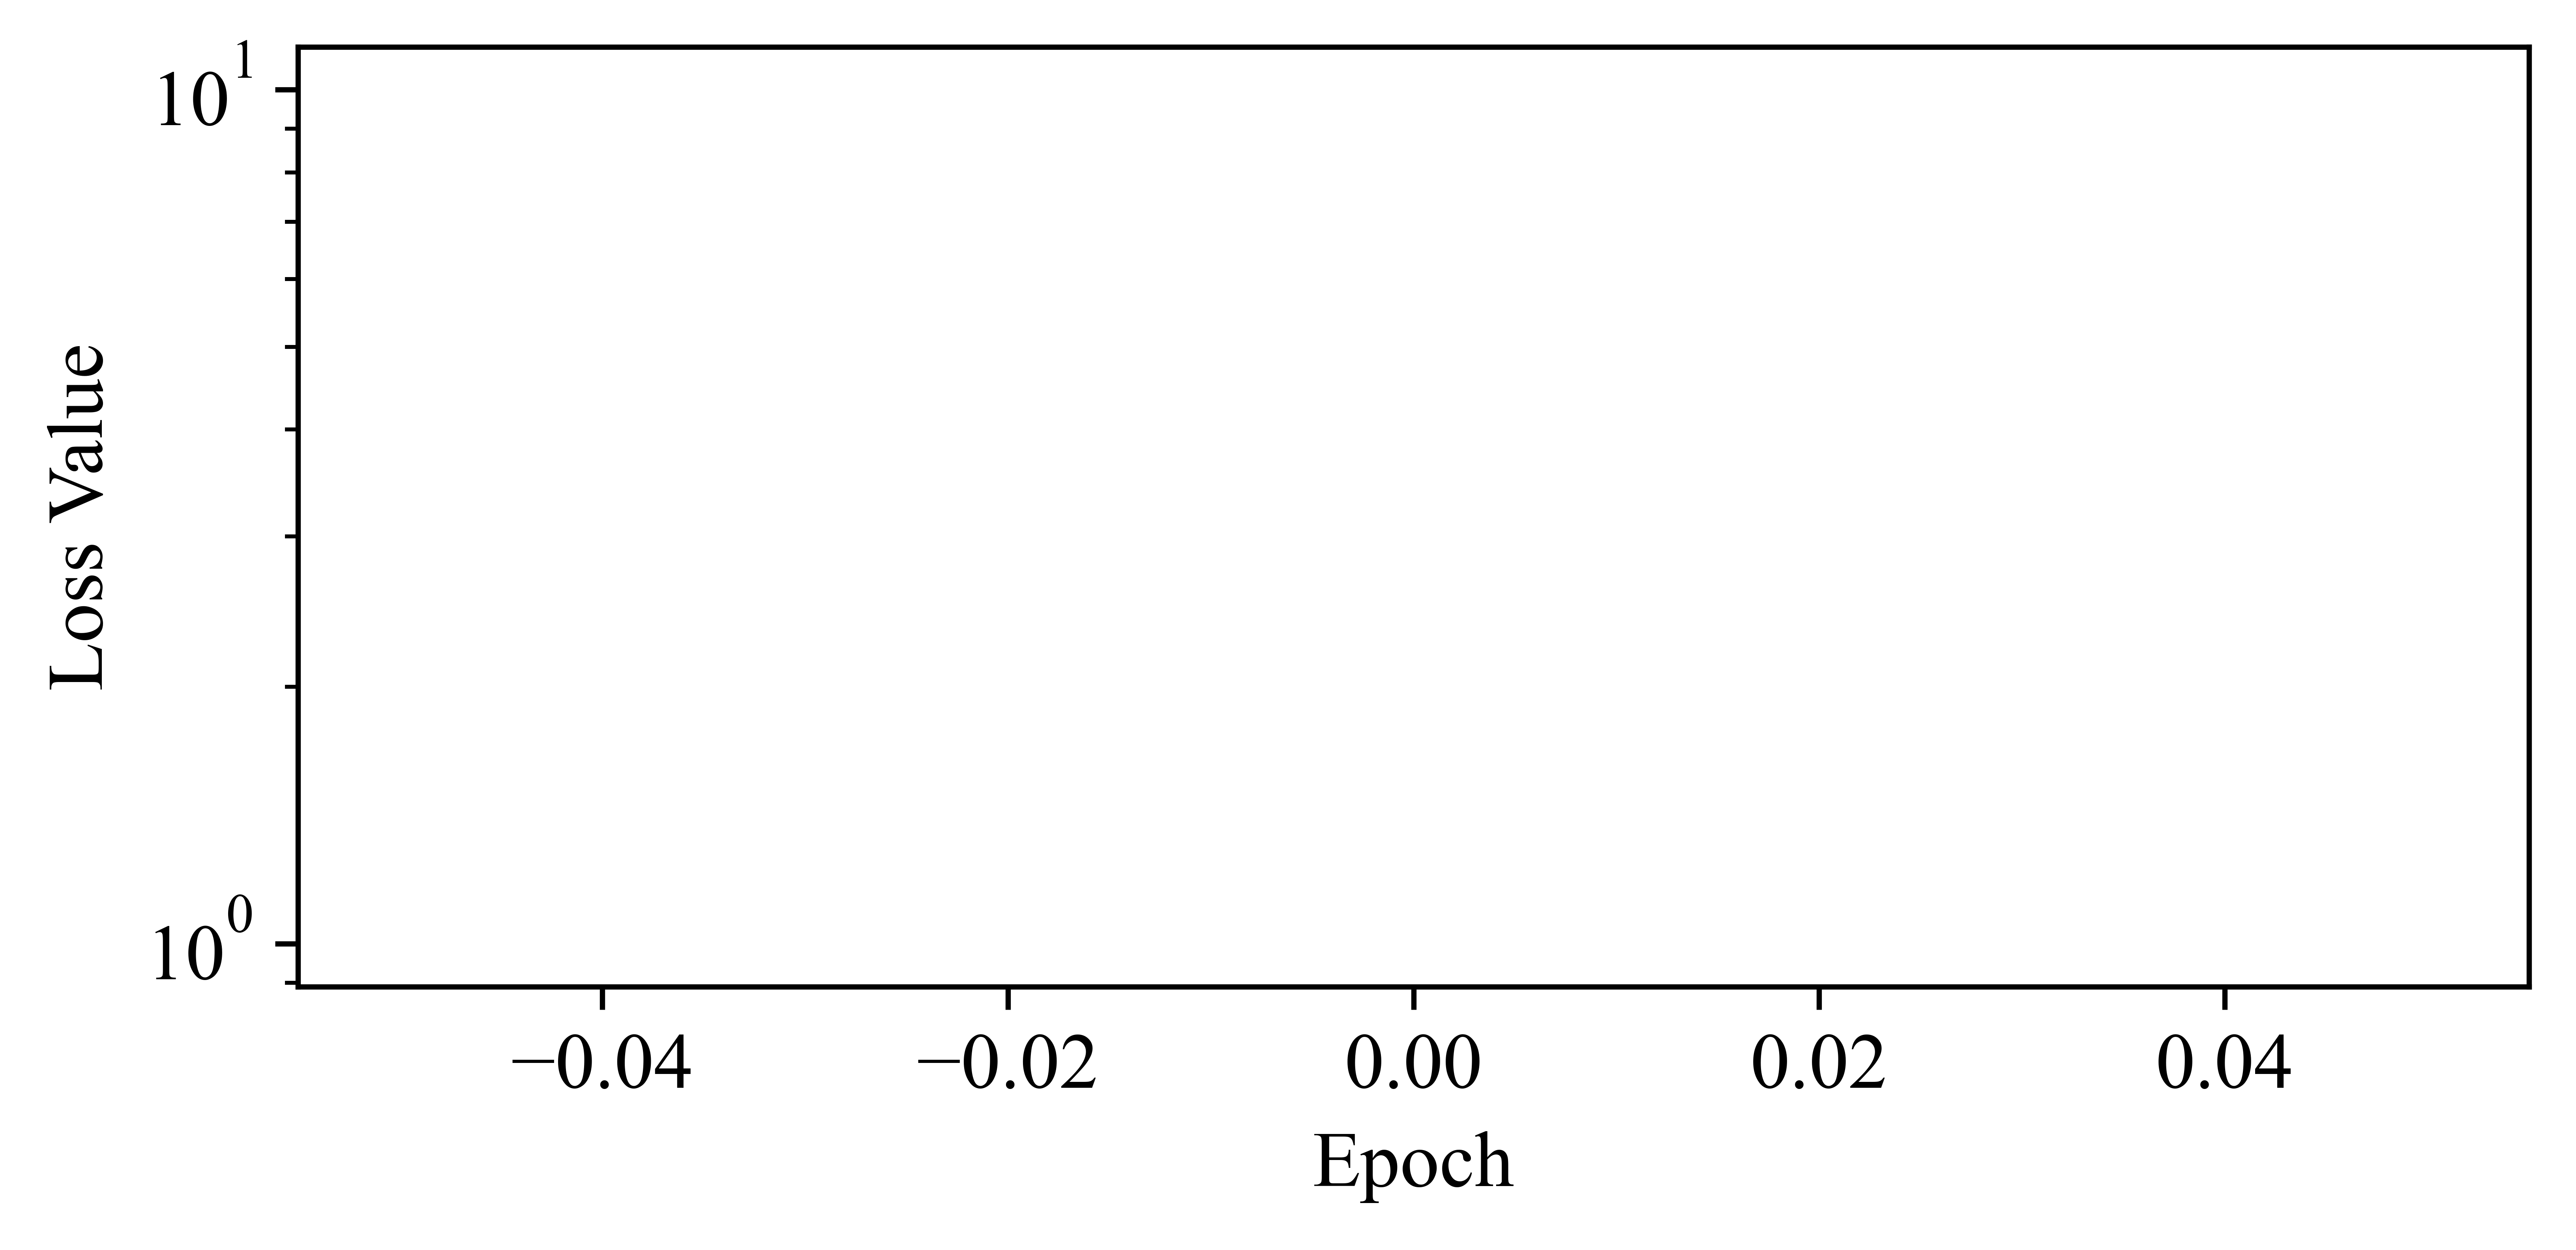

In [15]:
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.semilogy(loss_t)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.tight_layout()
# plt.savefig("fn_loss_output.png", transparent="True", bbox_inches="tight")

In [16]:
# model_2 = model.set_attributes(get_params(opt_state))

In [17]:

with open('win.npy', 'rb') as f:
    w_in = weight_opt = np.load(f)
with open('wrec.npy', 'rb') as f:
    w_rec = weight_opt = np.load(f)

model_2 = model.set_attributes({"0_LinearJax": {"weight": w_in}, "1_DynapSim": {"w_rec": w_rec}})


Output 1 = [[196.   0.]]
Output 2 = [[  0. 322.]]


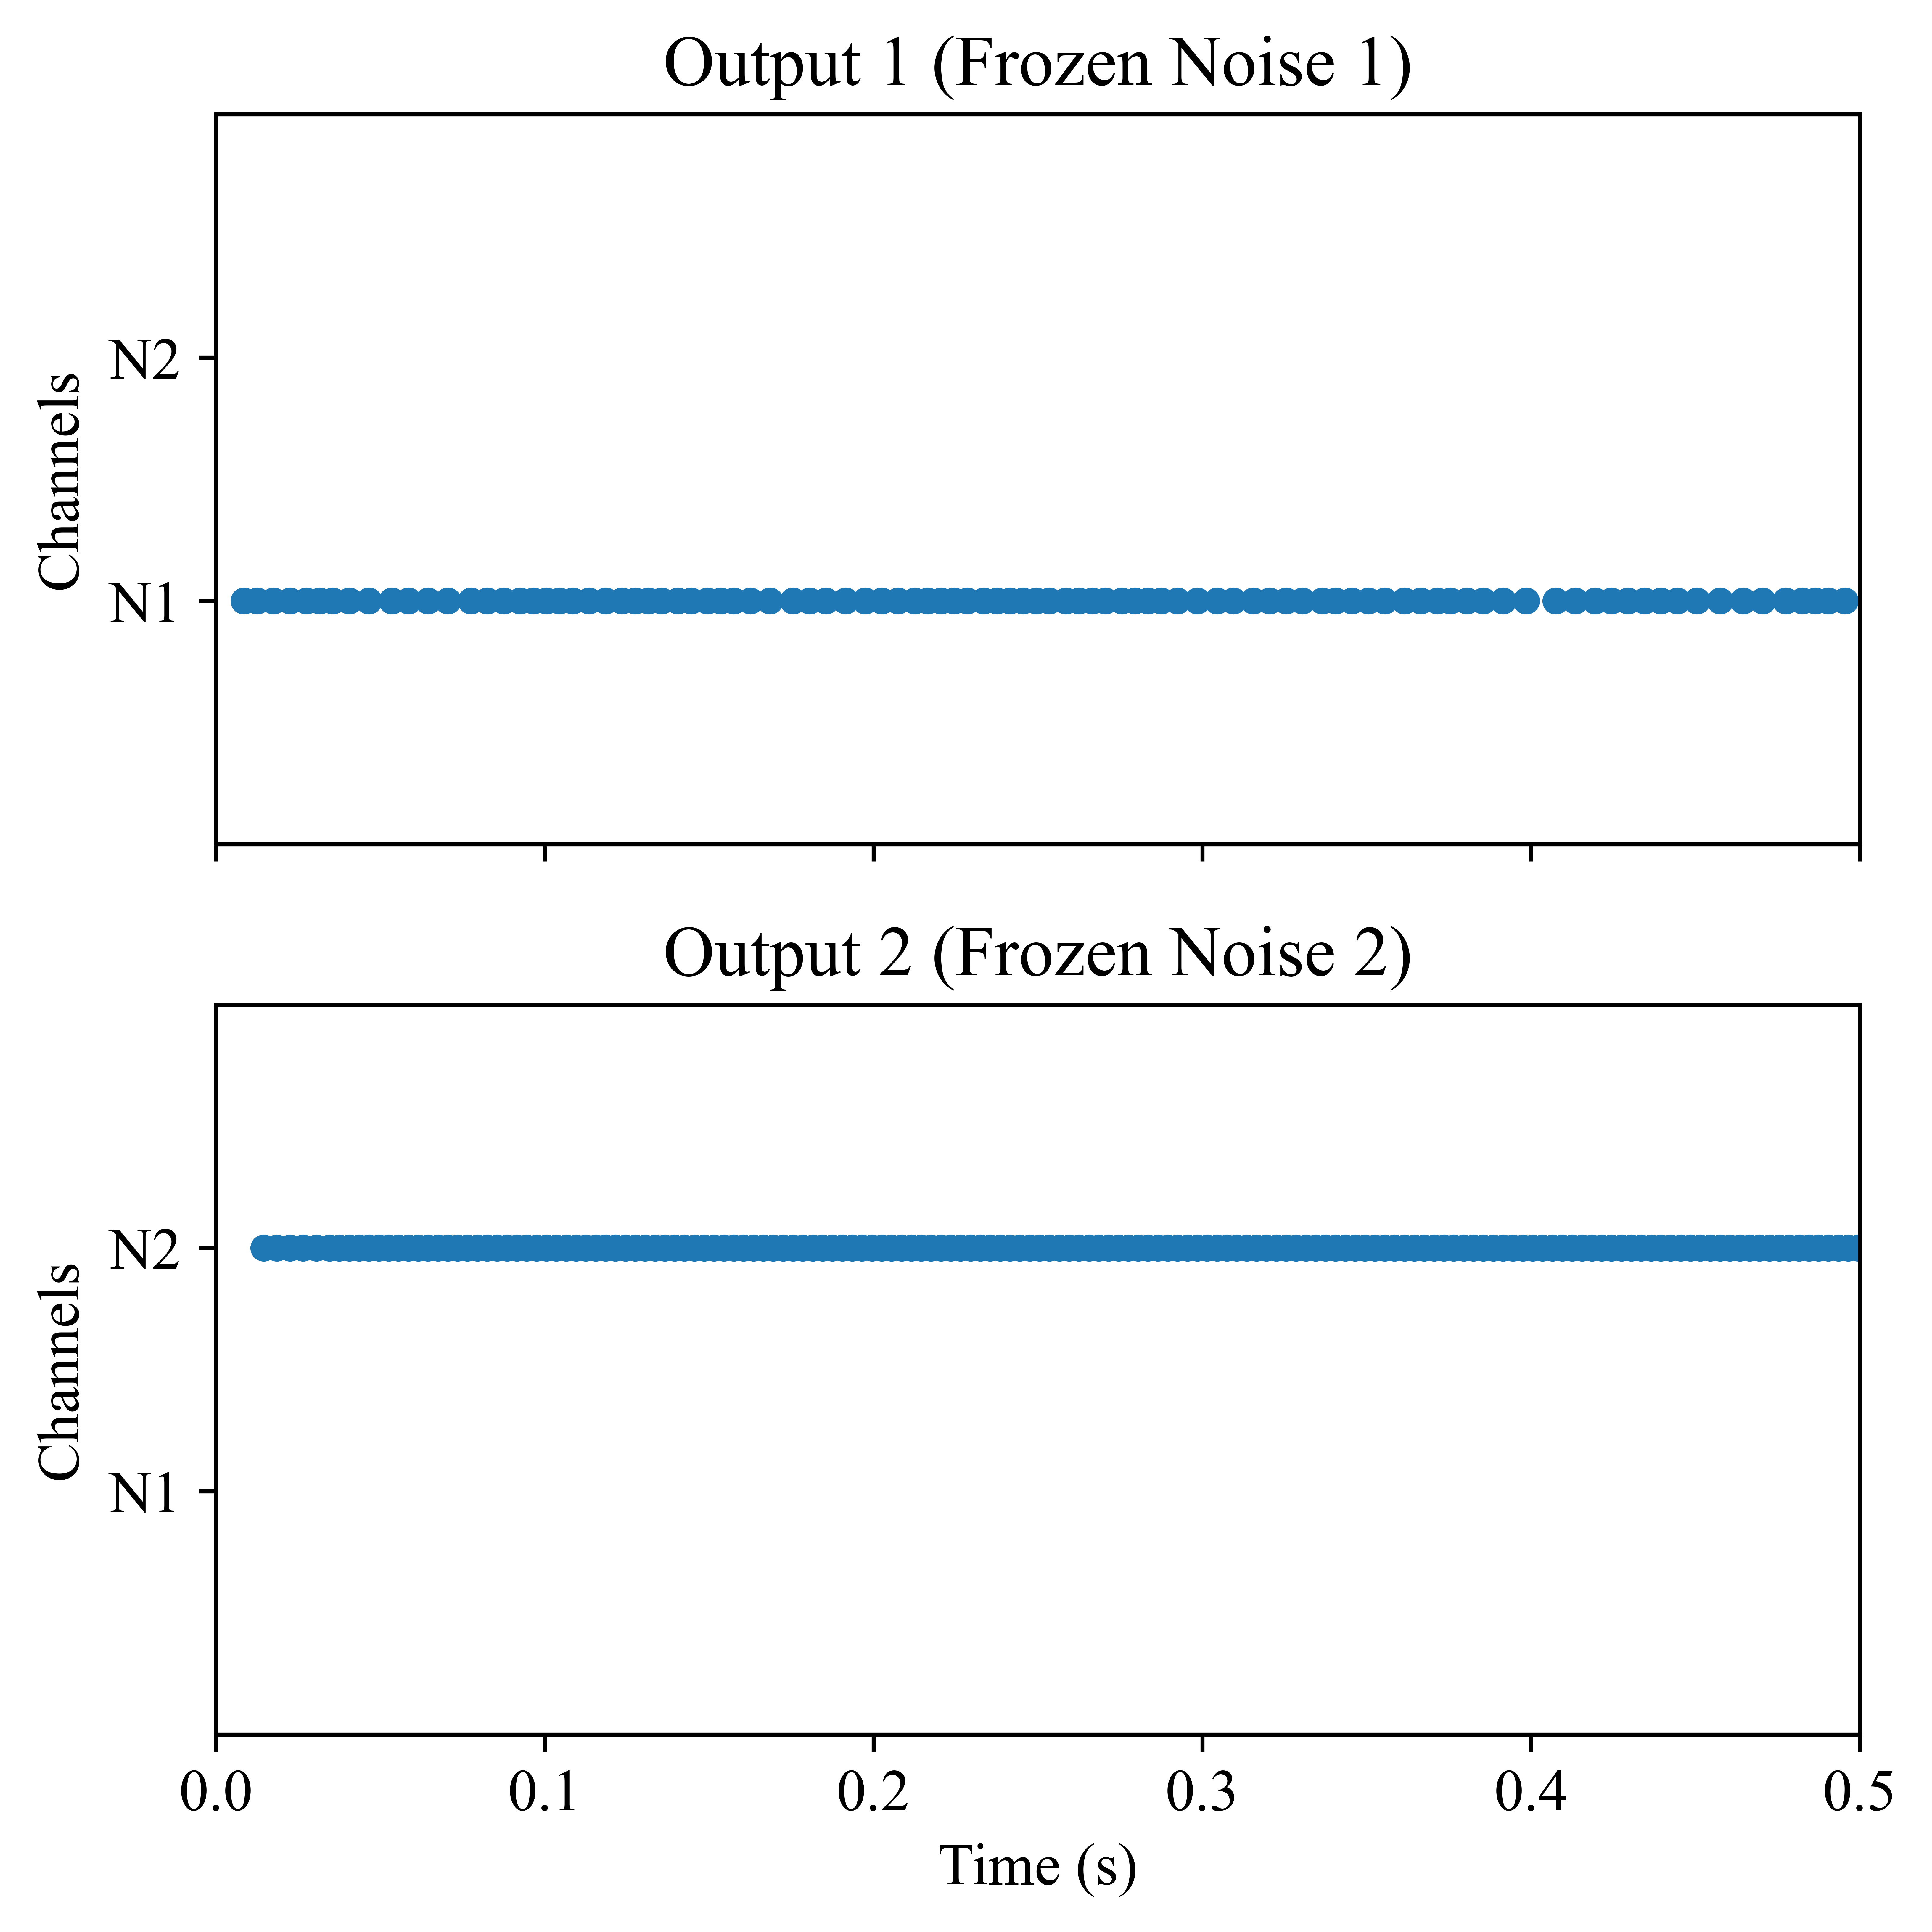

In [18]:
plt.rcParams["figure.figsize"] = [5.6, 5.6]
rec_2 = plot_output(model_2, dataset)
# plt.savefig("fn_output_optimized.png", transparent="True", bbox_inches="tight")

In [19]:
# plot_mem(rec_2)
# plt.savefig("fn_response_optimized.png", transparent="True", bbox_inches="tight")

In [20]:
# with open('win.npy', 'wb') as f:
#     np.save(f, np.array(model_2[0].weight))

# with open('wrec.npy', 'wb') as f:
#     np.save(f, model_2[1].w_rec)

In [21]:
model_2.as_graph()

GraphHolder "JaxSequential__12045331200" with 60 input nodes -> 2 output nodes

In [22]:
spec = mapper(model_2.as_graph())
spec

{'mapped_graph': GraphHolder "JaxSequential__12045331200" with 60 input nodes -> 2 output nodes,
 'weights_in': array([[-3.1249778e+00, -2.9268814e-02],
        [ 3.7045717e+00, -3.6795936e+00],
        [-7.9065981e+00, -7.7068391e+00],
        [-4.2382917e+00, -1.9721419e-01],
        [ 6.5543542e+00, -1.3694837e+00],
        [-5.8869500e+00, -4.2912207e+00],
        [-7.7625862e-03, -5.3019290e+00],
        [-5.2709889e+00, -2.5033751e+00],
        [-2.3468649e+00, -1.2699346e-03],
        [-4.4115429e+00, -8.2080621e-01],
        [ 2.6400316e-01,  2.1707831e-02],
        [-4.5025434e+00, -3.9648902e-02],
        [-7.1453285e+00,  3.4641141e-01],
        [-1.1053781e-03, -7.3175454e-01],
        [-5.8973899e+00, -7.5955123e-02],
        [-3.5209131e+00, -2.7969921e-01],
        [-5.3229246e+00, -3.0566442e+00],
        [-1.9294451e+00,  1.6098604e-01],
        [-4.2767839e+00, -1.0265994e-01],
        [ 6.1523194e+00, -1.2162733e+00],
        [-4.2616653e-01, -6.1684749e-03],
       

In [23]:
spec.update(parameter_clustering(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__12045331200" with 60 input nodes -> 2 output nodes,
 'weights_in': array([[-3.1249778e+00, -2.9268814e-02],
        [ 3.7045717e+00, -3.6795936e+00],
        [-7.9065981e+00, -7.7068391e+00],
        [-4.2382917e+00, -1.9721419e-01],
        [ 6.5543542e+00, -1.3694837e+00],
        [-5.8869500e+00, -4.2912207e+00],
        [-7.7625862e-03, -5.3019290e+00],
        [-5.2709889e+00, -2.5033751e+00],
        [-2.3468649e+00, -1.2699346e-03],
        [-4.4115429e+00, -8.2080621e-01],
        [ 2.6400316e-01,  2.1707831e-02],
        [-4.5025434e+00, -3.9648902e-02],
        [-7.1453285e+00,  3.4641141e-01],
        [-1.1053781e-03, -7.3175454e-01],
        [-5.8973899e+00, -7.5955123e-02],
        [-3.5209131e+00, -2.7969921e-01],
        [-5.3229246e+00, -3.0566442e+00],
        [-1.9294451e+00,  1.6098604e-01],
        [-4.2767839e+00, -1.0265994e-01],
        [ 6.1523194e+00, -1.2162733e+00],
        [-4.2616653e-01, -6.1684749e-03],
       

In [24]:
spec.update(autoencoder_quantization(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__12045331200" with 60 input nodes -> 2 output nodes,
 'weights_in': [array([[ 4,  0],
         [ 6,  2],
         [14, 11],
         [ 4,  0],
         [10,  1],
         [ 7,  8],
         [ 0,  5],
         [10,  4],
         [ 4,  0],
         [ 8,  0],
         [ 0,  0],
         [ 9,  0],
         [10,  0],
         [ 0,  0],
         [10,  0],
         [ 8,  0],
         [12,  4],
         [ 0,  0],
         [ 9,  1],
         [13,  0],
         [ 2,  0],
         [10, 10],
         [ 9,  6],
         [ 8,  5],
         [ 8,  4],
         [10,  0],
         [ 3,  0],
         [ 4,  0],
         [ 9,  0],
         [ 3,  5],
         [ 2,  0],
         [ 1,  1],
         [ 0,  0],
         [ 9,  5],
         [ 1,  0],
         [10,  4],
         [ 2,  0],
         [ 7,  0],
         [13,  0],
         [15,  4],
         [ 8,  0],
         [ 2,  0],
         [ 4,  8],
         [ 4,  0],
         [ 0,  1],
         [ 0,  1],
         [ 1,  

In [25]:
spec.update(config_from_specification(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__12045331200" with 60 input nodes -> 2 output nodes,
 'weights_in': [array([[ 4,  0],
         [ 6,  2],
         [14, 11],
         [ 4,  0],
         [10,  1],
         [ 7,  8],
         [ 0,  5],
         [10,  4],
         [ 4,  0],
         [ 8,  0],
         [ 0,  0],
         [ 9,  0],
         [10,  0],
         [ 0,  0],
         [10,  0],
         [ 8,  0],
         [12,  4],
         [ 0,  0],
         [ 9,  1],
         [13,  0],
         [ 2,  0],
         [10, 10],
         [ 9,  6],
         [ 8,  5],
         [ 8,  4],
         [10,  0],
         [ 3,  0],
         [ 4,  0],
         [ 9,  0],
         [ 3,  5],
         [ 2,  0],
         [ 1,  1],
         [ 0,  0],
         [ 9,  5],
         [ 1,  0],
         [10,  4],
         [ 2,  0],
         [ 7,  0],
         [13,  0],
         [15,  4],
         [ 8,  0],
         [ 2,  0],
         [ 4,  8],
         [ 4,  0],
         [ 0,  1],
         [ 0,  1],
         [ 1,  

In [26]:
## Connect to device
se2_devices = find_dynapse_boards()

found_se2 = len(se2_devices) > 0

if not found_se2:
    raise IOError('This tutorial requires a connected Dynap-SE2 Stack Board HDK to demonstrate.')
else:
    se2 = DynapseSamna((60,2),se2_devices[0], spec["config"])

In [27]:
dataset[0][0].shape

(500, 60)

In [28]:
def test_network(se2, spec, sample):

    se2.reset_state()
    out, state, rec = se2(sample, spec['input_channel_map'])

    fig, axes = plt.subplots(2, 1)

    ticks = list(rec["channel_map"].keys())
    labels = [dest.tag for dest in rec["channel_map"].values()]

    plt.sca(axes[0])
    TSEvent.from_raster(
        sample, t_start=rec["start_time"], t_stop=rec["stop_time"]+se2.dt, dt=se2.dt
    ).plot()
    plt.xlabel("")

    plt.sca(axes[1])
    TSEvent.from_raster(
        out, t_start=rec["start_time"], t_stop=rec["stop_time"]+se2.dt, dt=se2.dt
    ).plot(color="firebrick")
    plt.title("Device Output")
    plt.yticks(ticks, labels)
    plt.tight_layout()
    print(f"Rate = {np.sum(out)}")

Rate = 7.0


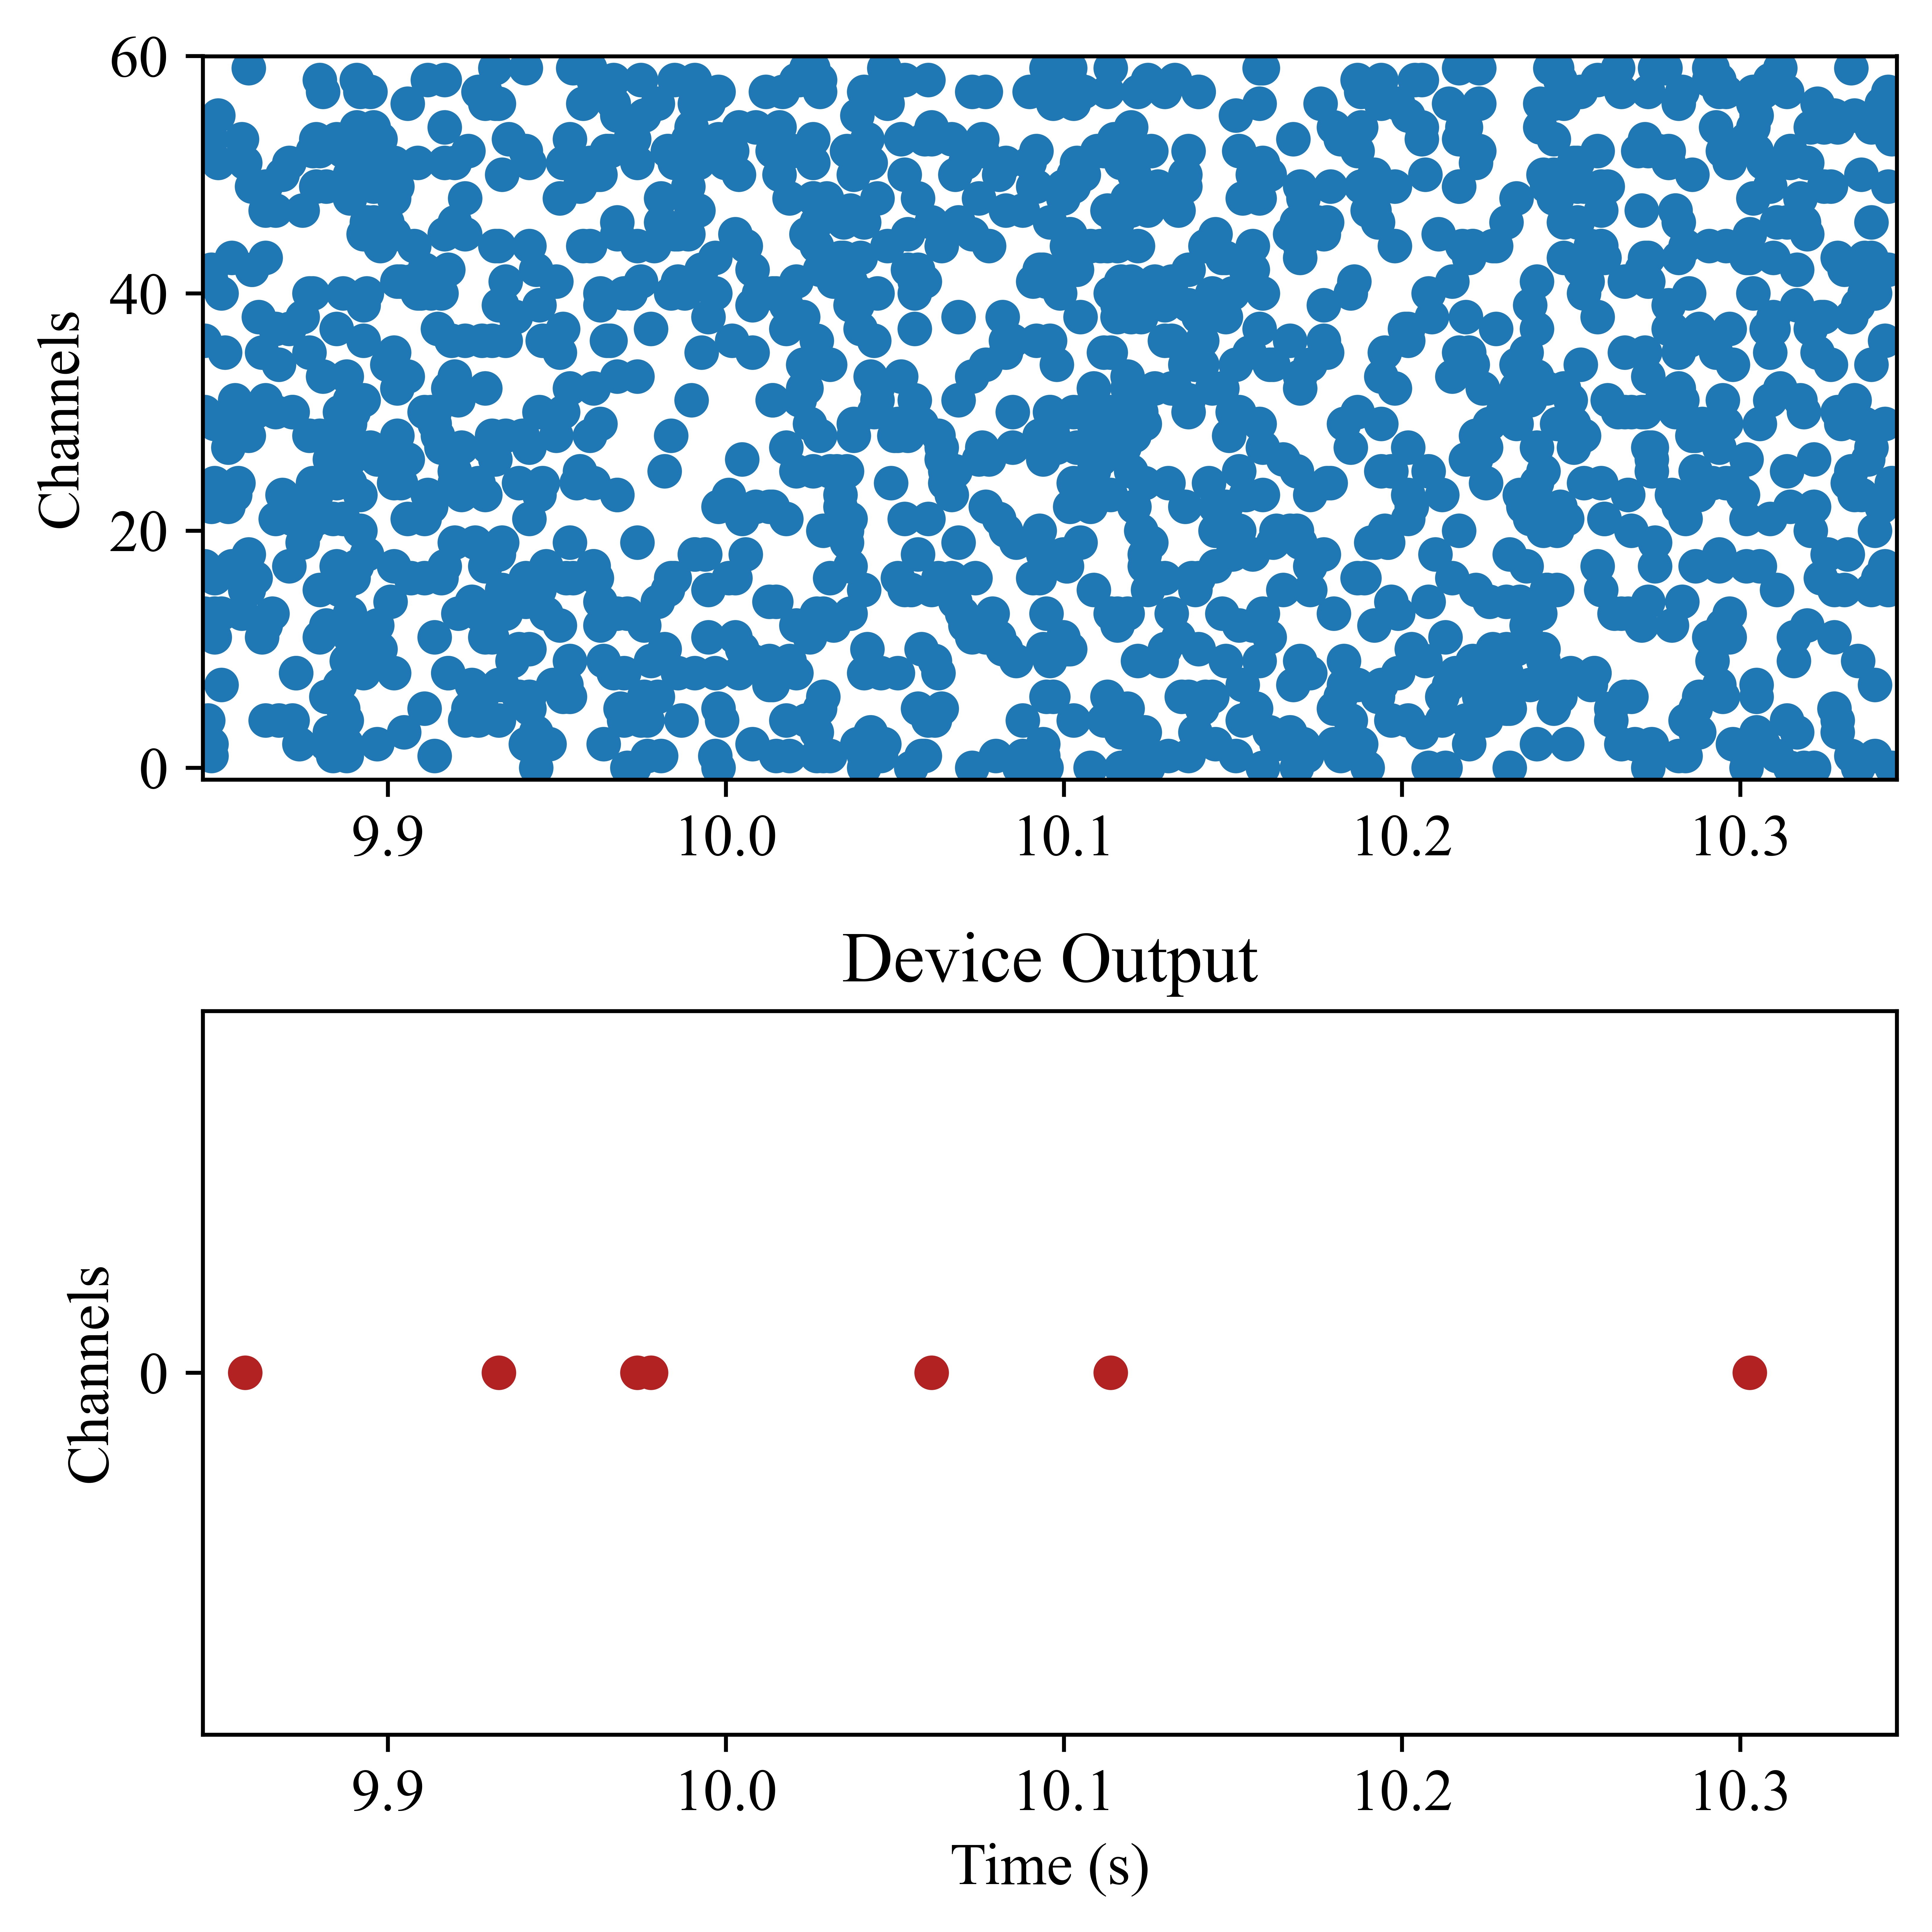

In [29]:
test_network(se2, spec, dataset[0][0])

Rate = 6.0


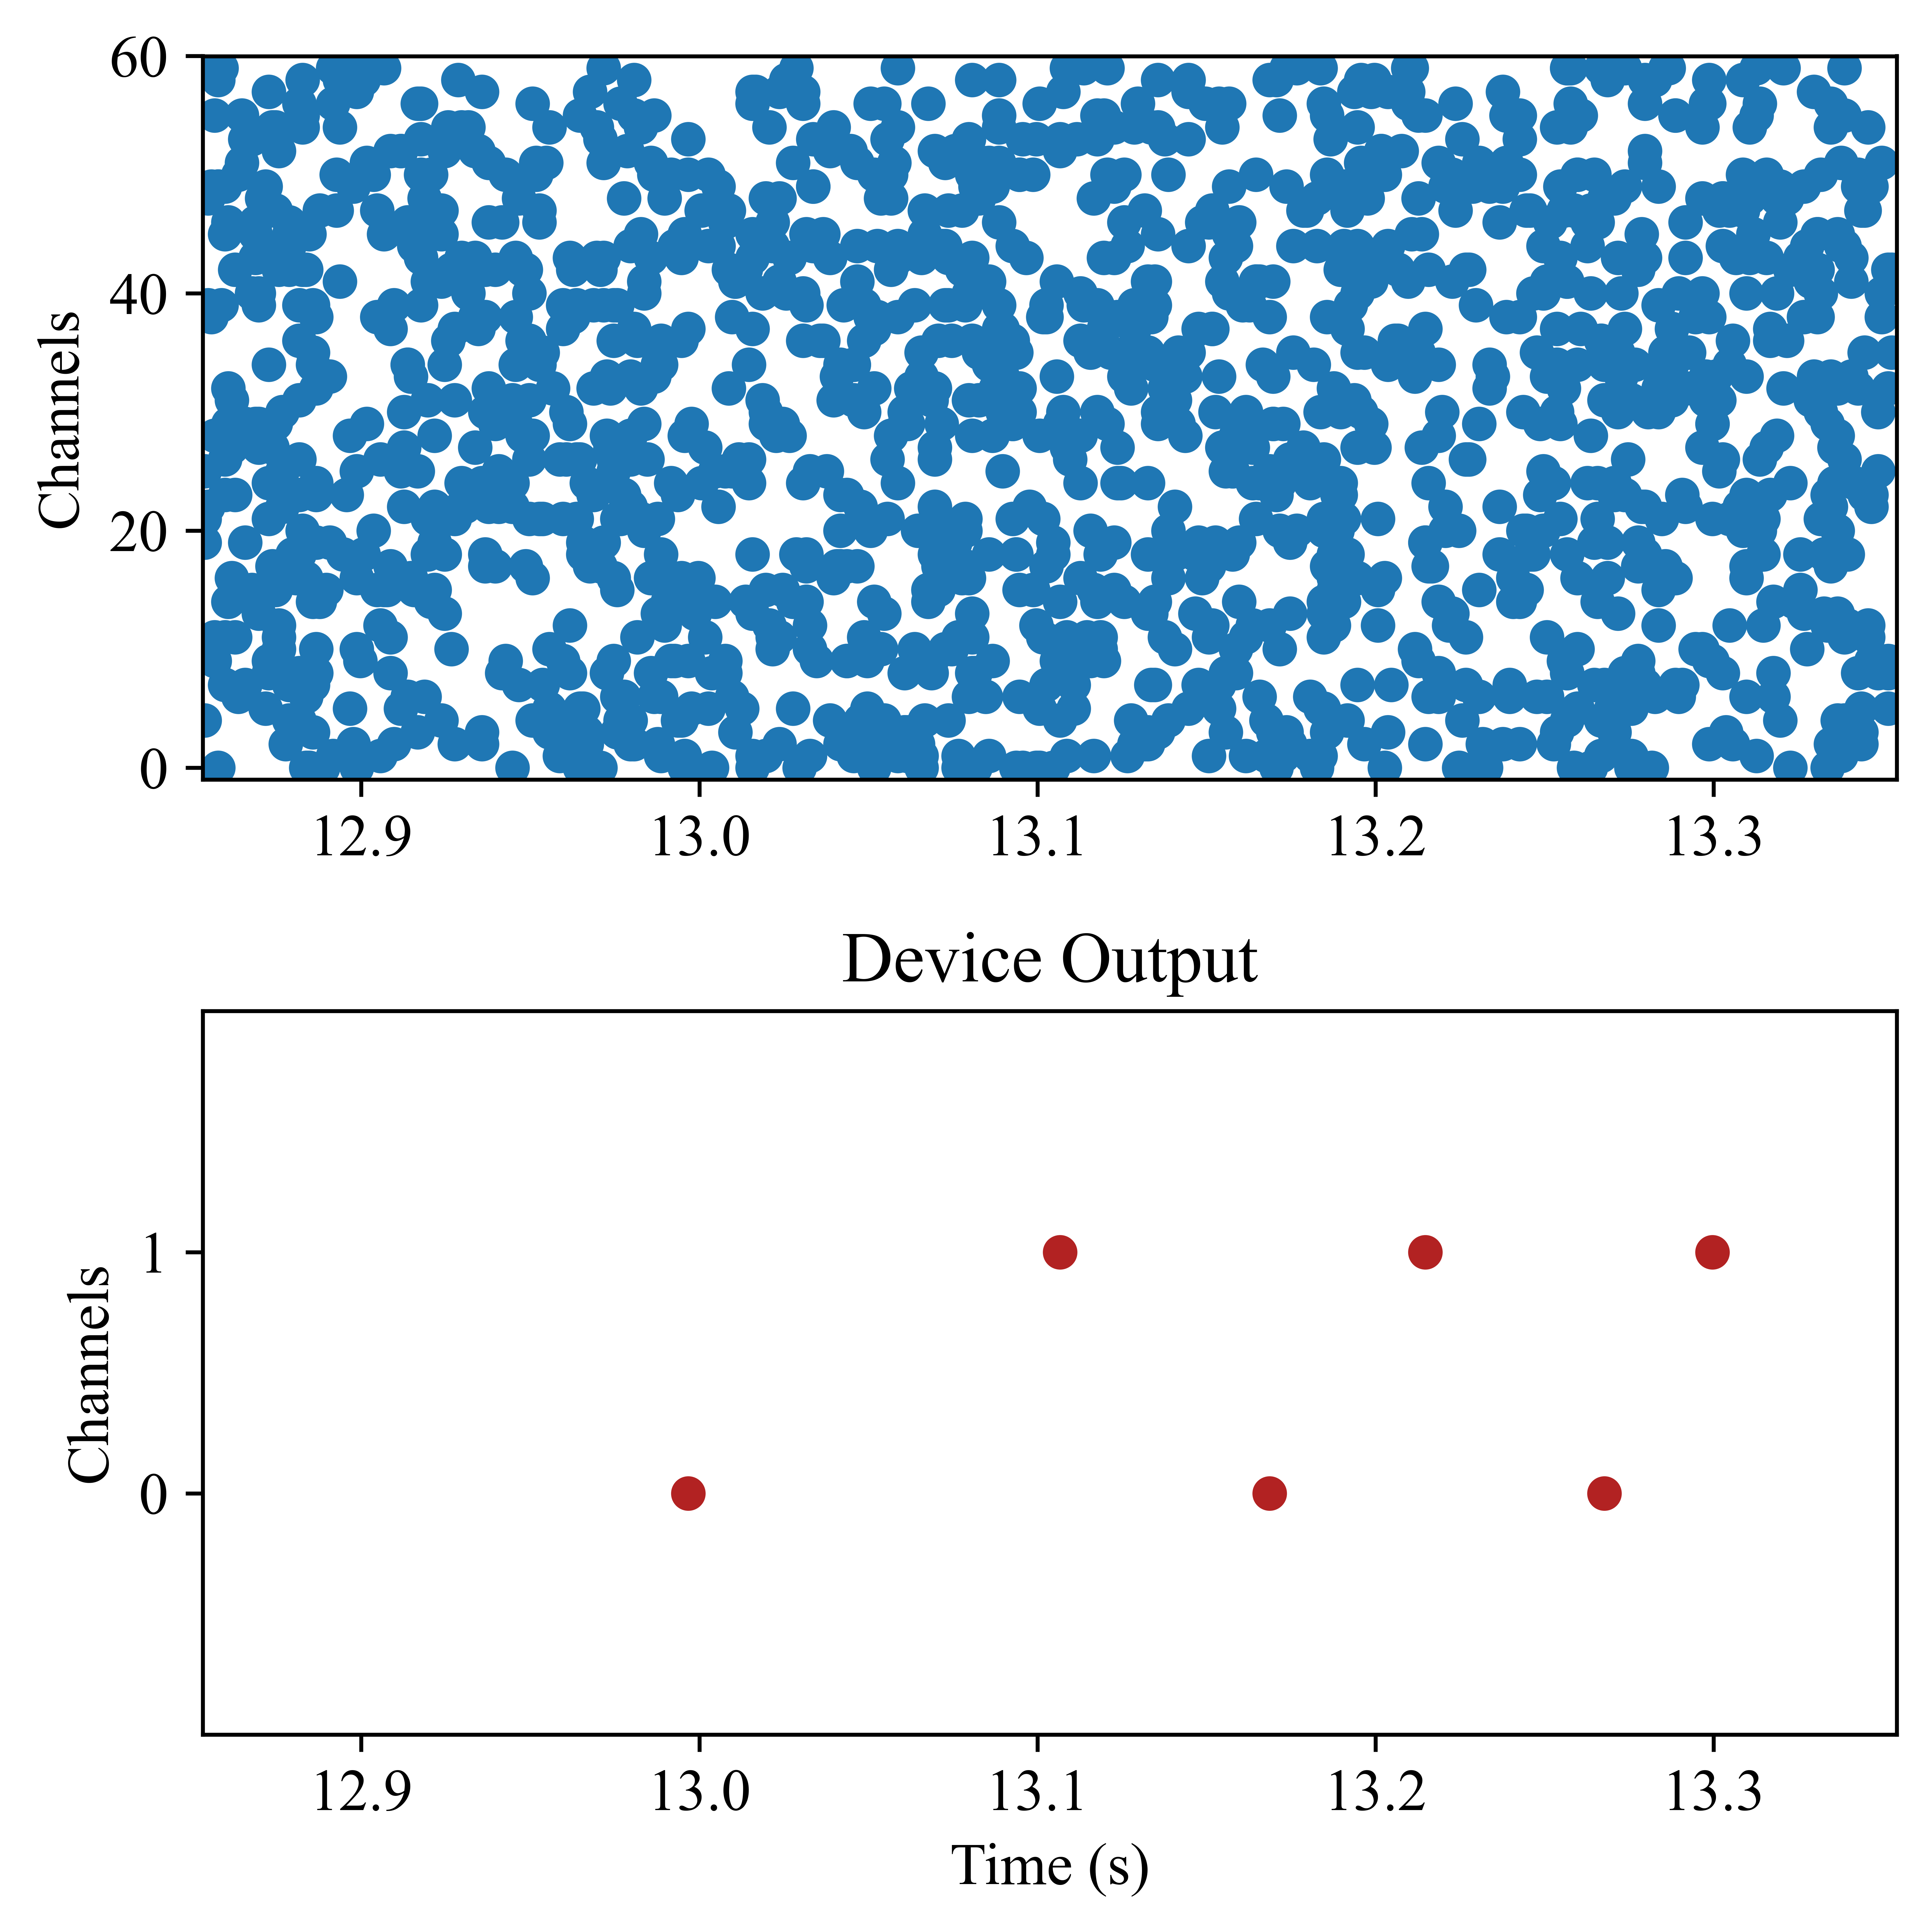

In [30]:
test_network(se2, spec, dataset2[5][0])